# DL Classifiers

---

Aditya Marathe

## Imports

In [67]:
%matplotlib inline

import sys

import numpy as np

import pandas as pd

# TensorFlow

import tensorflow as tf
from tensorflow import keras
import keras_tuner

# Metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

**Local:**

In [2]:
sys.path.insert(1, './../')

import ana
import plotting
import labbook

**Version:**

In [3]:
print(f'Python {sys.version}\n')
print(f'NumPy {np.__version__}')
print(f'Sci-kit Learn {tf.__version__}')

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]

NumPy 1.26.4
Sci-kit Learn 2.10.1


## Configuration

In [4]:
config = {
    'Cuts': [
        'Detector Quality',
        'Data Quality',
        'Cosmic Rej.',
        'Veto',
        'CVN PID Score',
        'Not Containment'
    ],
    'Transforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_280224_encode_event_type',
        'tf_280224_class_balance'
    ],
    'TestingTransforms': [
        'tf_290124_positive_energies',
        'tf_290124_valid_pid',
        'tf_280224_encode_event_type'
    ],
    'XDataCols': [
        # Loose pre-selection IDs
        'rec.sel.cvnloosepreselptp.cosmicid',
        'rec.sel.cvnloosepreselptp.ncid',
        'rec.sel.cvnloosepreselptp.numuid',
        # REM and SCP IDs
        'rec.sel.remid.pid',
        'rec.sel.scann.scpid',
        # Muon energies
        'rec.energy.numu.lstmmuon'
    ],
    'YDataCols': [
        'ana.cat.event_type'
    ]
}

## Loading training dataset

In [5]:
ds = ana.Datasets()

Datasets | Found the following: MINI_DATA_DIR, DATA_V2_DIR, DATA_V3_DIR, REALLY_MINI_DIR, COPYMERGED_C8_DIR, COPYMERGED_C9_DIR, COPYMERGED_C10_DIR, COPYMERGED_C11_DIR, COPYMERGED_C13_DIR, COPYMERGED_C15_DIR, COPYMERGED_C16_DIR, COPYMERGED_C17_DIR, COPYMERGED_C19_DIR, COPYMERGED_C20_DIR, COPYMERGED_C21_DIR, COPYMERGED_C22_DIR


In [6]:
data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C8_DIR,  # type: ignore
        ds.COPYMERGED_C9_DIR,  # type: ignore
        ds.COPYMERGED_C10_DIR,  # type: ignore
        ds.COPYMERGED_C11_DIR,  # type: ignore
        ds.COPYMERGED_C13_DIR,  # type: ignore
        ds.COPYMERGED_C15_DIR,  # type: ignore
        ds.COPYMERGED_C16_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from copymerged HDF5 files...
NOvAData | Loaded table from copymerged HDF5 files (1 / 7).
NOvAData | Loaded table from copymerged HDF5 files (2 / 7).
NOvAData | Loaded table from copymerged HDF5 files (3 / 7).
NOvAData | Loaded table from copymerged HDF5 files (4 / 7).
NOvAData | Loaded table from copymerged HDF5 files (5 / 7).
NOvAData | Loaded table from copymerged HDF5 files (6 / 7).
NOvAData | Loaded table from copymerged HDF5 files (7 / 7).
NOvAData | Initialised NOvAData(features=54, events=1_094_528).


In [7]:
data.fill_ana_flags(inplace=True)
data.fill_ana_track_kinematics(inplace=True)
data.fill_categorical(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled track kinematics.
NOvAData | Filled categorical data.


In [8]:
cuts = ana.Cuts.init_nova_cuts()

In [9]:
# Cuts
data.table = cuts.apply_cuts(config['Cuts'][:-1], data.table)
data.table = cuts.apply_cut('Containment', data.table, passed=False)


Cuts     | Applied 'Detector Quality' cut (1_094_528 -> 919_711 events).
Cuts     | Applied 'Data Quality' cut (919_711 -> 919_688 events).
Cuts     | Applied 'Cosmic Rej.' cut (919_688 -> 351_421 events).
Cuts     | Applied 'Veto' cut (351_421 -> 313_034 events).
Cuts     | Applied 'CVN PID Score' cut (313_034 -> 196_427 events).
Cuts     | Applied 'Containment' cut (196_427 -> 105_055 events).


In [10]:
# Transforms
data.apply_transforms(config['Transforms'], inplace=True)

NOvAData | Applied a transform which cuts out the negative energies caused by issues with the reco. models.
NOvAData | Applied a transform which ensures that the PID score is between 0 and 1.
NOvAData | Applied a transform which encodes the event type as 1 for (A-)NuMu CC and 0 for background.
NOvAData | Applied a transform which balances the number of events for each class.


In [11]:
data.table.head()

rec.energy.numu.E  \
run   subrun cycle batch evt subevt                      
14746 41     0     0     173 1                0.822706   
                         652 1                0.822706   
14750 20     0     0     699 1                1.001116   
                         793 2                2.867611   
14754 16     0     0     461 2                1.859418   

                                     rec.energy.numu.calccE  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.816658   
                         652 1                     0.816658   
14750 20     0     0     699 1                     1.070769   
                         793 2                     3.288869   
14754 16     0     0     461 2                     1.658546   

                                     rec.energy.numu.hadcalE  \
run   subrun cycle batch evt subevt                            
14746 41     0     0     173 1                      0.004180   
                         652 1                      0.004180   
14750 20     0     0     699 1                      0.190039   
                         793 2                      0.728458   
14754 16     0     0     461 2                      0.022085   

                                     rec.energy.numu.hadtrkE  \
run   subrun cycle batch evt subevt                            
14746 41     0     0     173 1                      0.009910   
                         652 1                      0.009910   
14750 20     0     0     699 1                      0.024564   
                         793 2                      0.010688   
14754 16     0     0     461 2                      0.007007   

                                     rec.energy.numu.lstmmuon  \
run   subrun cycle batch evt subevt                             
14746 41     0     0     173 1                       0.787001   
                         652 1                       0.787001   
14750 20     0     0     699 1                       0.554846   
                         793 2                       2.563976   
14754 16     0     0     461 2                       1.886155   

                                     rec.energy.numu.lstmnu  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.870839   
                         652 1                     0.870839   
14750 20     0     0     699 1                     0.997018   
                         793 2                     3.151421   
14754 16     0     0     461 2                     2.024810   

                                     rec.energy.numu.regcvnhadE  \
run   subrun cycle batch evt subevt                               
14746 41     0     0     173 1                         0.074651   
                         652 1                         0.074651   
14750 20     0     0     699 1                         0.612823   
                         793 2                         0.924363   
14754 16     0     0     461 2                         0.094978   

                                     rec.energy.numu.trkccE  \
run   subrun cycle batch evt subevt                           
14746 41     0     0     173 1                     0.822706   
                         652 1                     0.822706   
14750 20     0     0     699 1                     1.001116   
                         793 2                     2.867611   
14754 16     0     0     461 2                     1.859418   

                                     rec.energy.numu.recomuonE  \
run   subrun cycle batch evt subevt                              
14746 41     0     0     173 1                        0.783632   
                         652 1                        0.783632   
14750 20     0     0     699 1                        0.560385   
                         793 2                        1.465072   
14754 16     0     0     461 2                        1.790292   

                 

In [12]:
std_scaler = StandardScaler()

scale_vars = [
    'rec.energy.numu.lstmmuon'
]

In [13]:
tt_split = data.train_test_split(
    x_cols=config['XDataCols'],
    y_cols=config['YDataCols'],
    test_size=0.3
)

tt_split['XTrain'].loc[:, scale_vars] = std_scaler.fit_transform(
    tt_split['XTrain'][scale_vars]
)
tt_split['XTest'].loc[:, scale_vars] = std_scaler.transform(
    tt_split['XTest'][scale_vars]
)
tt_split['YTrain'] = tt_split['YTrain'].to_numpy().flatten()
tt_split['YTest'] = tt_split['YTest'].to_numpy().flatten()

## Loading testing dataset

In [14]:
test_data = ana.NOvAData.init_from_copymerge_h5(
    h5dirs=[
        ds.COPYMERGED_C19_DIR,  # type: ignore
        ds.COPYMERGED_C20_DIR,  # type: ignore
        ds.COPYMERGED_C21_DIR,  # type: ignore
        ds.COPYMERGED_C22_DIR  # type: ignore
    ]
)

NOvAData | Loading tables from copymerged HDF5 files...
NOvAData | Loaded table from copymerged HDF5 files (1 / 4).
NOvAData | Loaded table from copymerged HDF5 files (2 / 4).
NOvAData | Loaded table from copymerged HDF5 files (3 / 4).
NOvAData | Loaded table from copymerged HDF5 files (4 / 4).
NOvAData | Initialised NOvAData(features=54, events=671_350).


In [15]:
test_data.fill_ana_flags(inplace=True)
test_data.fill_categorical(inplace=True)
test_data.fill_ana_track_kinematics(inplace=True)

NOvAData | Filled MC truth flags.
NOvAData | Filled categorical data.
NOvAData | Filled track kinematics.


In [16]:
test_data.apply_transforms(config['TestingTransforms'], inplace=True)

NOvAData | Applied a transform which cuts out the negative energies caused by issues with the reco. models.
NOvAData | Applied a transform which ensures that the PID score is between 0 and 1.
NOvAData | Applied a transform which only keeps data for the first prong.
NOvAData | Applied a transform which encodes the event type as 1 for (A-)NuMu CC and 0 for background.


In [17]:
# Cuts
fail_cont_table = cuts.apply_cuts(config['Cuts'][:-1], test_data.table)
fail_cont_table = cuts.apply_cut('Containment', fail_cont_table, passed=False)

Cuts     | Applied 'Detector Quality' cut (275_579 -> 264_421 events).
Cuts     | Applied 'Data Quality' cut (264_421 -> 264_421 events).
Cuts     | Applied 'Cosmic Rej.' cut (264_421 -> 149_447 events).
Cuts     | Applied 'Veto' cut (149_447 -> 141_050 events).
Cuts     | Applied 'CVN PID Score' cut (141_050 -> 95_669 events).
Cuts     | Applied 'Containment' cut (95_669 -> 47_822 events).


In [18]:
# Cuts
full_cut_table = cuts.apply_all_cuts(test_data.table)

Cuts     | Applied 'Detector Quality' cut (275_579 -> 264_421 events).
Cuts     | Applied 'Data Quality' cut (264_421 -> 264_421 events).
Cuts     | Applied 'CVN PID Score' cut (264_421 -> 101_766 events).
Cuts     | Applied 'Containment' cut (101_766 -> 48_577 events).
Cuts     | Applied 'Cosmic Rej.' cut (48_577 -> 47_955 events).
Cuts     | Applied 'Veto' cut (47_955 -> 47_847 events).


In [19]:
x_test_data = fail_cont_table[config['XDataCols']]
y_test_data = fail_cont_table[config['YDataCols']].to_numpy()

In [20]:
x_test_data.loc[:, scale_vars] = std_scaler.transform(x_test_data[scale_vars])

C:\Users\Shrey\AppData\Local\Temp\ipykernel_18396\1053093416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_data.loc[:, scale_vars] = std_scaler.transform(x_test_data[scale_vars])


## Model

In [100]:
def build_model(hp: keras_tuner.HyperParameters) -> keras.Sequential:
    model = keras.Sequential(
        layers=[
            keras.layers.Input(
                shape=(len(config['XDataCols']),),
                name='input'
            ),
            keras.layers.Dense(
                hp.Choice('units-1', [8, 16, 32, 64, 128]),
                activation=keras.activations.relu,
                name='dense-1'
            ),
            keras.layers.Dense(
                hp.Choice('units-2', [8, 16, 32, 64, 128]),
                activation=keras.activations.relu,
                name='dense-2'
            ),
            keras.layers.Dropout(
                hp.Choice('rate-1', [0.0, 0.2, 0.4, 0.6, 0.8]),
                name='dropout-1'
            ),
            keras.layers.Dense(
                hp.Choice('units-3', [8, 16, 32, 64, 128]),
                activation=keras.activations.relu,
                name='dense-3'
            ),
            keras.layers.Dense(
                hp.Choice('units-4', [8, 16, 32, 64, 128]),
                activation=keras.activations.relu,
                name='dense-4'
            ),
            keras.layers.Dropout(
                hp.Choice('rate-2', [0.0, 0.2, 0.4, 0.6, 0.8]),
                name='dropout-2'
            ),
            keras.layers.Dense(
                units=1,
                activation=keras.activations.sigmoid,
                name='output'
            )
        ],
        name='model'
    )
    model.compile(
        loss=keras.losses.binary_crossentropy,
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1E-4, 1E-3, 1E-2, 1E-1]),
            name='adam'
        ),
        metrics=[
            keras.metrics.BinaryAccuracy(name='bin_accuracy'),
            keras.metrics.Precision(name='precision')
        ]
    )
    return model


In [117]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective=keras_tuner.Objective('precision', direction='max'),
    max_trials=10,
    project_name='dl_classifier_tuner',
    overwrite=True
)

In [118]:
tuner.search(
    x=tt_split['XTrain'].to_numpy(),
    y=tt_split['YTrain'],
    validation_split=0.2,
    epochs=50
)

Trial 10 Complete [00h 00m 12s]
precision: 1.0

Best precision So Far: 1.0
Total elapsed time: 00h 02m 01s


In [108]:
model = tuner.get_best_models()[0]

In [109]:
tuner.get_best_hyperparameters()[0].values

{'units-1': 16,
 'units-2': 32,
 'rate-1': 0.8,
 'units-3': 16,
 'units-4': 16,
 'rate-2': 0.0,
 'learning_rate': 0.0001}

In [110]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense-1 (Dense)             (None, 16)                112       
                                                                 
 dense-2 (Dense)             (None, 32)                544       
                                                                 
 dropout-1 (Dropout)         (None, 32)                0         
                                                                 
 dense-3 (Dense)             (None, 16)                528       
                                                                 
 dense-4 (Dense)             (None, 16)                272       
                                                                 
 dropout-2 (Dropout)         (None, 16)                0         
                                                                 
 output (Dense)              (None, 1)                 17    

In [86]:
# history_obj = model.fit(
#     x=tt_split['XTrain'].to_numpy(),
#     y=tt_split['YTrain'],
#     validation_split=0.2,
#     epochs=100
# )

## Analysis

In [119]:
y_predicted = model.predict(x_test_data.to_numpy())

1495/1495 [==============================] - 5s 3ms/step


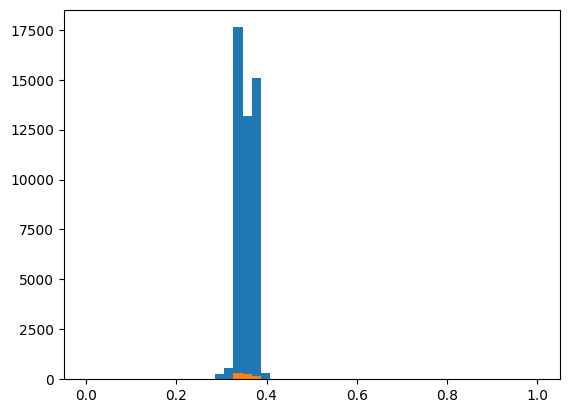

In [120]:
plt.hist(
    y_predicted[y_test_data == 1],
    bins=np.linspace(0, 1, 50)
)
plt.hist(
    y_predicted[y_test_data == 0],
    bins=np.linspace(0, 1, 50)
);

In [64]:
pd.Series(y_test_data.flatten()).value_counts()

1    47071
0      751
Name: count, dtype: int64

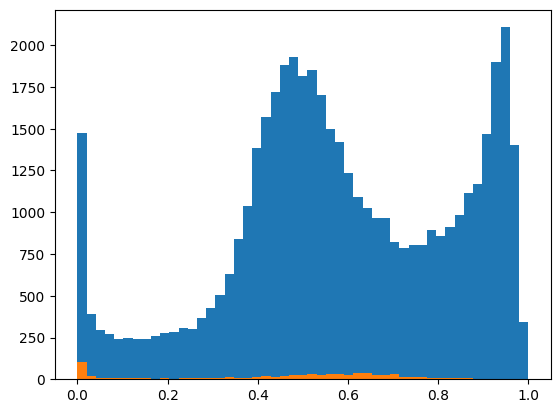

In [65]:
plt.hist(
    y_predicted.flatten()[y_test_data.flatten() == 1],
    bins=np.linspace(0, 1, 50)
)
plt.hist(
    y_predicted.flatten()[y_test_data.flatten() == 0],
    bins=np.linspace(0, 1, 50)
);

In [68]:
ana_kwargs = {'y_true': y_test_data, 'y_pred': y_predicted}

Accuracy = 0.42288068253105265
Precision = 0.9912705621152488
Recall = 0.4173482611374307


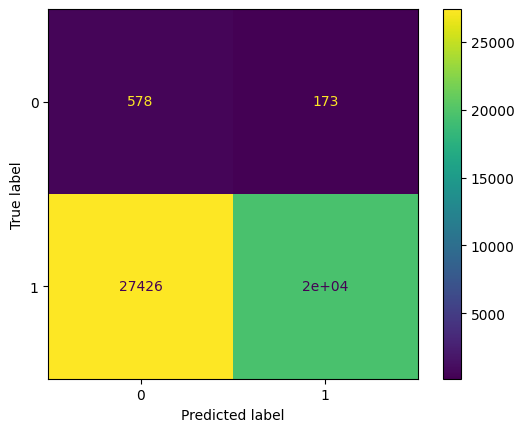

In [69]:
acc = accuracy_score(**ana_kwargs)
pre = precision_score(**ana_kwargs)
rec = recall_score(**ana_kwargs)

cm = confusion_matrix(**ana_kwargs)

print('Accuracy =', acc)
print('Precision =', pre)
print('Recall =', rec)

ConfusionMatrixDisplay(cm).plot();

In [70]:
cm[0, 1] * 100 / cm[1, 1]

0.8806312038686689

## Labbook

In [ ]:
# labbook.LabBookApplication('./../../labbook').mainloop()

In [ ]:
comments = f"""\
Classifier: Random Forest
-------------------------

No class balancing was attempted.

Found best hyperparameters using randomized grid search by maximising the \
precision.

The best hyperparameters were:
{rs_result.best_params_}

The best score (precision) was: {rs_result.best_score_}

The following variables were standardised:
{scale_vars}
"""

In [ ]:
labbook.add_log_skl(
    comments=comments,
    config_dict=config,
    model=model,
    lb_dir='./../../labbook',
    serialise_objects={
        'StandardScaler': std_scaler,
        'ScaleVars': scale_vars
    }
)